In [3]:
import numpy as np
import torch
from dataset import create_EEG_dataset
import torchvision.transforms as transforms
from einops import rearrange
import os

class Config_Generative_Model:
    def __init__(self):
        self.seed = 2022
        self.root_path = '/workspace/eeg_reconstruction/daekun/mamba-test/'
        self.output_path = '/workspace/eeg_reconstruction/daekun/mamba-test/exps/'

        self.eeg_signals_path = os.path.join('/workspace/eeg_reconstruction/shared/brain2image/eeg_5_95_std.pth')
        self.splits_path = os.path.join('/workspace/eeg_reconstruction/shared/brain2image/block_splits_by_image_single.pth')
        
        self.crop_ratio = 0.2
        self.img_size = 512
        self.subject = 4

config = Config_Generative_Model()

crop_pix = int(config.crop_ratio*config.img_size)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(config.seed)
np.random.seed(config.seed)

In [4]:
# Helper transforms
def normalize(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
    img = torch.tensor(img)
    img = img * 2.0 - 1.0 # to -1 ~ 1
    return img

class random_crop:
    def __init__(self, size, p):
        self.size = size
        self.p = p
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return transforms.RandomCrop(size=(self.size, self.size))(img)
        return img
    
def channel_last(img):
        if img.shape[-1] == 3:
            return img
        return rearrange(img, 'c h w -> h w c')

# Define image transforms
img_transform_train = transforms.Compose([
    normalize,

    transforms.Resize((512, 512)),
    random_crop(config.img_size-crop_pix, p=0.5),

    transforms.Resize((512, 512)),
    channel_last
])
img_transform_test = transforms.Compose([
    normalize, 

    transforms.Resize((512, 512)),
    channel_last
])

eeg_latents_dataset_train, eeg_latents_dataset_test = create_EEG_dataset(eeg_signals_path = config.eeg_signals_path, splits_path = config.splits_path, 
                image_transform=[img_transform_train, img_transform_test], subject = config.subject)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [5]:
# Visualize the data
example_train = next(iter(eeg_latents_dataset_train))

eeg = example_train["eeg"]
label = example_train["label"]
image = example_train["image"]
image_raw = example_train["image_raw"] # this loads a torch tensor that is normalized and 224 size

/workspace/eeg_reconstruction/alston/miniforge3/envs/mindeye-eeg/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


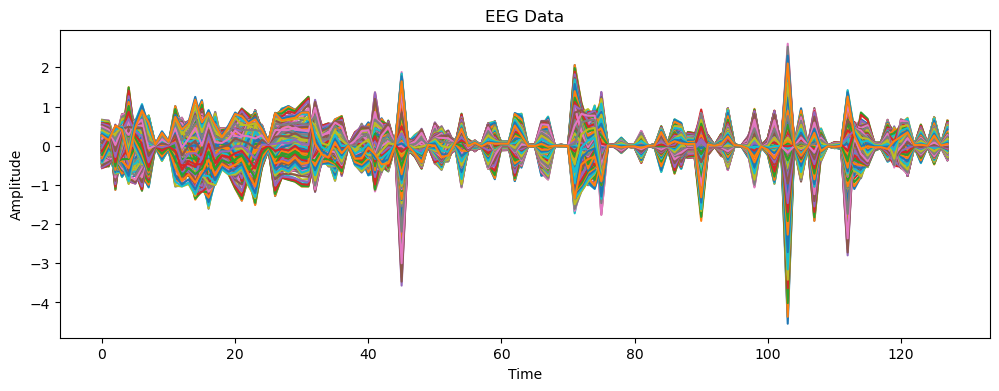

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor(10)


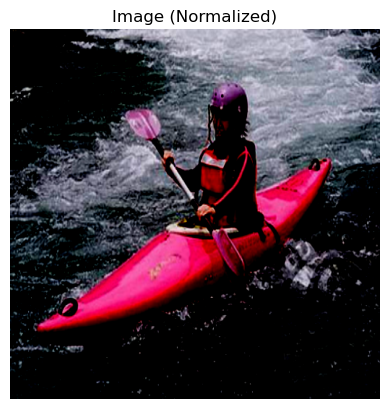

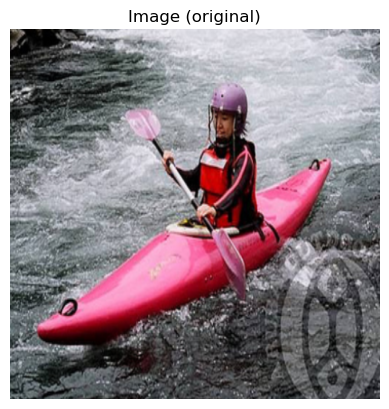

In [6]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Plotting EEG data
plt.figure(figsize=(12, 4))
plt.plot(eeg)
plt.title("EEG Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Displaying Label
print("Label:", label)

# Visualizing image (assuming it's a numpy array)
plt.figure()
plt.imshow(image)
plt.title("Image (Normalized)")
plt.axis('off')
plt.show()

# Visualizing original image
plt.figure()
gt_image = (image + 1.0) / 2.0
gt_image = np.clip(gt_image, 0.0, 1.0)
# if it's a torch tensor
# gt_image = torch.clamp((gt_image+1.0)/2.0, min=0.0, max=1.0)
plt.imshow(gt_image)
plt.title("Image (original)")
plt.axis('off')
plt.show()